In [86]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc

import cmocean


from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

import scipy as sp
from scipy import interpolate
from scipy import signal
from scipy.interpolate import griddata


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Reading in coarse velocity data that I previously saved

In [87]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs = xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]
depth_coarse= depth[::10,::10]

lon=fs['geolon_t'][::10,::10]; lat=fs['geolat_t'][::10,::10]
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_c']/360 *2*np.pi);

%cd /work/eay/
u_full = xr.open_dataset('u_1year_CM2.6.nc')['u_full']
v_full = xr.open_dataset('v_1year_CM2.6.nc')['v_full']
zl = v_full.st_ocean

%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history
time = xr.open_dataset('02010101.ocean_minibling_field_u.nc')['time'] #,'02020101.ocean_minibling_field_u.nc'
print('done')


/net2/smg/documents/OMDT/analysis_CM2p6/grids
/work2/eay
/arch2/rds/CM2.6/CM2.6_A_Control-1860_V03/history


/nbhome/eay/anaconda3/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


done


In [88]:
#u_eddy = u_full - u_full.mean('time')
v_eddy = v_full - v_full.mean('time')
v_eddy = v_eddy[0::7]
print(v_eddy.shape)

(11, 50, 270, 360)


In [26]:
#u_eddy_sn = (u_eddy[-1,:])
v_eddy_sn = (v_eddy[-1,:])

print(v_eddy_sn.shape)
print(v_eddy.shape)

(50, 270, 360)
(10, 50, 270, 360)


In [27]:
print(v_eddy_sn[0,0,0])

<xarray.DataArray 'v_full' ()>
array(nan, dtype=float32)
Coordinates:
    xu_ocean  float64 -279.9
    yu_ocean  float64 -81.09
    st_ocean  float64 5.034
    time      object 0201-02-17 12:00:00


In [28]:
# rs_grid = np.arange(0,1,0.02)
# rs_train_v = np.zeros(v_eddy.shape)*np.nan
# for i in range(v_eddy.shape[2]): #270
#     for j in range(v_eddy.shape[3]): #360
#         for ti in range(v_eddy.shape[0]): #73
#             if(~np.isnan(v_eddy[ti,0,i,j])):
#                 if(v_eddy[ti,0,i,j]<0):
#                     this_p_u = v_eddy[ti,:,i,j]*-1  #Surface value is positive for all cases for consistency
#                 else:
#                     this_p_u = v_eddy[ti,:,i,j]
                
#                 max_depth= depth_coarse[i,j]                   
#                 g = np.where(~np.isnan(this_p_u))[0]

#                 rs_train_v[ti,:,i,j] = np.interp(rs_grid, zl[g]/max_depth, this_p_u[g])
#     print(i)  
# Takes 1-2 hours

In [89]:
rs_grid = np.arange(0,1,0.02)
rs_train_v = np.zeros(v_eddy.shape)*np.nan
for i in range(v_eddy.shape[2]): #270
    for j in range(v_eddy.shape[3]): #360
        if(~np.isnan(v_eddy[0,0,i,j])):

            this_p_v = v_eddy[0,:,i,j]
                
            max_depth= depth_coarse[i,j]                   
            g = np.where(~np.isnan(this_p_v))[0]
            
            for ti in range(v_eddy.shape[0]): #360
                profile = v_eddy[ti,:,i,j]
                rs_train_v[ti,:,i,j] = np.interp(rs_grid, zl[g]/max_depth, profile[g])
    print(i)  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


In [90]:
rs_train_v.shape

(11, 50, 270, 360)

In [91]:
# g = np.where(~np.isnan(v_eddy_sn[:,100,100]))[0]
# plt.plot(rs_grid,rs_train_v[:,100,100],'r')
# plt.plot(zl[g]/depth_coarse[100,100],v_eddy_sn[g,100,100],'b')

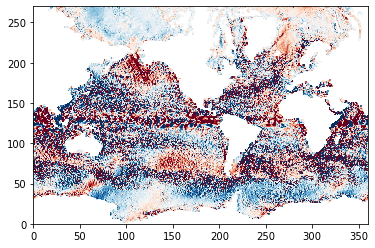

In [92]:
plt.pcolor(rs_train_v[0,0,:,:],vmin=-.1,vmax=.1,cmap='RdBu_r')

In [116]:
# #Reshape into a 2D array and normalize:
transposed = np.transpose(rs_train_v, (1, 2, 3, 0))
transposed.shape
v_eddy_r = np.array(transposed).reshape(50,270*360*11)

print(v_eddy_r.shape)
ind = np.where(~np.isnan(v_eddy_r[0,:]))[0]
v_eddy_r = v_eddy_r[:,ind]
#v_eddy_r = preprocessing.normalize(v_eddy_r,norm='l2')

print(v_eddy_r.shape)



(50, 1069200)
(50, 666248)


In [117]:
# ############# PCA ################
        
# PCA on total spectra flattened array
pca = PCA(6)  #pca that accounts for 95% of the data; alternatively say number of PCs
lower_dimensional_data = pca.fit_transform(np.transpose(v_eddy_r))
print(lower_dimensional_data.shape)
        
########### GMM ###################        
# GMM on lower dimensional data
gmm = GaussianMixture(n_components=5, covariance_type='full',random_state=0).fit(lower_dimensional_data) 
#gmm = GaussianMixture(n_components=5).fit(lower_dimensional_data) 

labels = gmm.predict(lower_dimensional_data)
print(labels.shape)

(666248, 6)
(666248,)


In [118]:
# # -- PCA (U)
# pca = PCA(n_components=6)
# # -- fit the PCA to the training data
# pca.fit(np.transpose(v_eddy_r))
# # -- transform the training data to reduced PCA/EOF space
# X_pca_train = pca.transform(np.transpose(v_eddy_r))
# # -- get the variance explained by each principal component
# variance_sum = np.cumsum(pca.explained_variance_ratio_)
# print(variance_sum)

# gmm = GaussianMixture(n_components=5, covariance_type='full',random_state=0).fit(lower_dimensional_data) 
# labels = gmm.predict(lower_dimensional_data)
# print(labels.shape)

In [119]:
v_eddy_r[:,labels==0].shape

(50, 127409)

In [120]:
#data_array = np.transpose(v_eddy_r)

label1 = np.mean(abs(v_eddy_r[:,labels==0]),axis=1)
label1_std = np.std(abs(v_eddy_r[:,labels==0]),axis=1)

label2 = np.mean(abs(v_eddy_r[:,labels==1]),axis=1)
label2_std = np.std(abs(v_eddy_r[:,labels==1]),axis=1)

label3 = np.mean(abs(v_eddy_r[:,labels==2]),axis=1)
label3_std = np.std(abs(v_eddy_r[:,labels==2]),axis=1)

label4 = np.mean(abs(v_eddy_r[:,labels==3]),axis=1)
label4_std = np.std(abs(v_eddy_r[:,labels==3]),axis=1)

label5 = np.mean(abs(v_eddy_r[:,labels==4]),axis=1)
label5_std = np.std(abs(v_eddy_r[:,labels==4]),axis=1)


In [121]:
label1_std*100

array([4.42743501, 4.13415892, 4.02502797, 3.86288959, 3.69552063,
       3.54003149, 3.39524902, 3.25841059, 3.13356118, 3.01936285,
       2.91531648, 2.82065263, 2.7350292 , 2.65721292, 2.58618928,
       2.52085048, 2.46127563, 2.40703062, 2.35755873, 2.31250234,
       2.27169448, 2.23477631, 2.2016203 , 2.1728074 , 2.14753601,
       2.12630462, 2.10782589, 2.09310054, 2.08205605, 2.07437604,
       2.06966534, 2.06800975, 2.06473603, 2.06231731, 2.06220506,
       2.06398574, 2.0668578 , 2.071315  , 2.07705627, 2.08397768,
       2.09172539, 2.1008688 , 2.11158432, 2.12363275, 2.1366082 ,
       2.15013003, 2.16413823, 2.17818279, 2.19156896, 2.20359242])

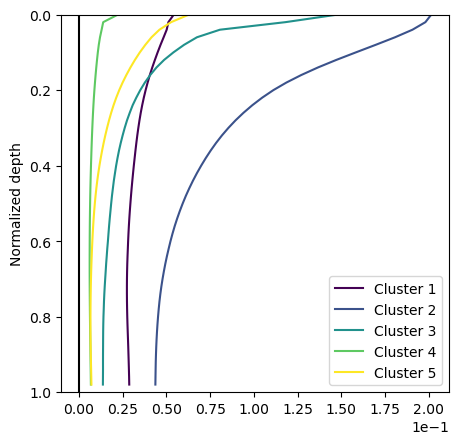

In [123]:
plt.figure(figsize=(5,5),dpi=100)

colors = plt.cm.viridis(np.linspace(0,1,5))
plt.plot(label1,rs_grid,color=colors[0],label='Cluster 1')
#plt.fill_betweenx(rs_grid, label1-label1_std, x2=label1+label1_std, color=colors[0],alpha=.5)

plt.plot(label2,rs_grid,color=colors[1],label='Cluster 2')
#plt.fill_betweenx(rs_grid, label2-label2_std, x2=label2+label2_std, color=colors[1],alpha=.5)
#
plt.plot(label3,rs_grid,color=colors[2],label='Cluster 3')

plt.plot(label4,rs_grid,color=colors[3],label='Cluster 4')
#plt.fill_betweenx(rs_grid, label4-label4_std, x2=label4+label4_std, color=colors[3],alpha=.5)

plt.plot(label5,rs_grid,color=colors[4],label='Cluster 5')
#plt.fill_betweenx(rs_grid, label5-label5_std, x2=label5+label5_std, color=colors[4],alpha=.5)

plt.plot([0,0],[0,1],'k')
#plt.gca().invert_yaxis()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim([1,0])
plt.ylabel('Normalized depth')
plt.legend()

In [124]:
land_mask = depth_coarse.fillna(1)
land_mask = land_mask.where(land_mask==1)

lon_coarse=depth_coarse.xt_ocean
lat_coarse=depth_coarse.yt_ocean


In [125]:
full_data = np.empty([1069200])*np.nan
full_data[ind]=labels
print(ind.shape,labels.shape)
labels_2D=full_data.reshape(270,360,11)
labels_2D.shape

(666248,) (666248,)


(270, 360, 11)

Text(0.5, 0, 'Longitude')

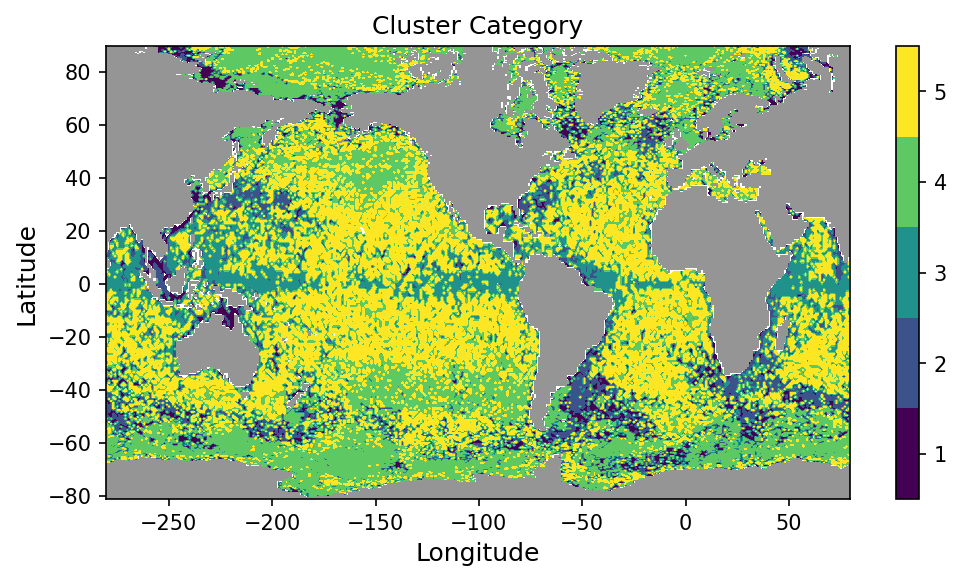

In [130]:

fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

levels=np.linspace(.5,5.5,6)

plot1 = plt.contourf(lon_coarse,lat_coarse,labels_2D[:,:,6]+1,cmap='viridis',levels=levels,vmin=1,vmax=5)
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);
#plt.colorbar(ticks=[1, 2, 3, 4])
plt.colorbar(ticks=[1, 2, 3, 4,5])

plt.title('Cluster Category',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)
